<a href="https://colab.research.google.com/github/cyuancheng/NLP_Yelp_review/blob/master/NLP_2_yelp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Natural Language Processing and Sentiment Analysis for Yelp##

Explore Starbucks review in New York City

In [0]:
import pandas as pd
import requests
import spacy #use NLP functions
from spacy import displacy
from textblob import TextBlob
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import folium
import warnings
warnings.filterwarnings("ignore")

###1. Data pre-process and cleaning###
Get data from Yelp api

In [0]:
#get yelp api (https://www.yelp.com/developers)

client_id = 'fl6Gc_WOT5VLrae0o6fc7w' 
key = 'kArR8ttjf4JdZDtC27-InwcgepdkWrtTcSfaHKwf_JMtQY0LvXgfaG3lmUA3F2oCCp-KUa-W8tPuVXdm8Abwj6N0m0YJniJHVa61rXEFMLuAM11d2IrYSV5NEYGJXHYx'

ENDPOINT = 'https://api.yelp.com/v3/businesses/search'

HEADERS = {'Authorization':'bearer {}'.format(key)}

PARAMETERS = {'term' : 'Starbucks',
              'limit':50,
             'radius':40000, # meter
              'latitude': 40.758862,
              'longitude':-73.978663  # Rockefeller Center
              #'sort_by' :'review_count', 
             #'location':"New York City"
             }

response = requests.get(url = ENDPOINT, params = PARAMETERS, headers = HEADERS)

- Process/Clean business data

In [0]:
data = response.json()

In [4]:
data["businesses"][0]

{'alias': 'starbucks-new-york-273',
 'categories': [{'alias': 'coffee', 'title': 'Coffee & Tea'}],
 'coordinates': {'latitude': 40.758856, 'longitude': -73.978954},
 'display_phone': '(212) 397-7950',
 'distance': 24.51886376624723,
 'id': '5WHpzFh-ZbTBY919PlZPTw',
 'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/6f8_MgbQJiloz02QX6Oqxw/o.jpg',
 'is_closed': False,
 'location': {'address1': '30 Rockefeller Plaza',
  'address2': '',
  'address3': '',
  'city': 'New York',
  'country': 'US',
  'display_address': ['30 Rockefeller Plaza', 'New York, NY 10112'],
  'state': 'NY',
  'zip_code': '10112'},
 'name': 'Starbucks',
 'phone': '+12123977950',
 'price': '$$',
 'rating': 3.0,
 'review_count': 72,
 'transactions': [],
 'url': 'https://www.yelp.com/biz/starbucks-new-york-273?adjust_creative=fl6Gc_WOT5VLrae0o6fc7w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=fl6Gc_WOT5VLrae0o6fc7w'}

Next, we can make a list of the businesses with their id, rating, price, and location

In [0]:
# list of id in businesses with rating
list_buss = []

for item in data['businesses']:
  try:
    list_buss.append([item['id'], item['rating'], item['price'],item['review_count'],\
                      item['coordinates']['latitude'],item['coordinates']['longitude'] ])
  except:
    list_buss.append([item['id'], item['rating'], None, None, None, None])

In [8]:
# convert to pandas format
list_buss = pd.DataFrame(list_buss, columns = ['id','rating','price', 'count', 'latitude','longitude' ])
list_buss.head()

,id,rating,price,count,latitude,longitude
0,5WHpzFh-ZbTBY919PlZPTw,3.0,$$,72.0,40.758856,-73.978954
1,AJR1lIu3RzgC8bgCk2tFog,2.5,$$,30.0,40.758859,-73.978956
2,t8_nm5-yk8ArhZjT3nHxRA,2.5,$$,15.0,40.757802,-73.979602
3,DTRLsTwx0534Iv-0xfXijA,2.5,$$,26.0,40.760364,-73.979084
4,4VwDtb5wOxfaXFOvTp7C6A,2.5,$$,22.0,40.760587,-73.978598


In [9]:
locations = list_buss[['latitude', 'longitude']]
locationlist = locations.values.tolist()
len(locationlist)
locationlist[7]

[40.760348, -73.976134]

In [14]:
map = folium.Map(location=[40.758862, -73.978663], zoom_start=16)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=list_buss['id'][point]).add_to(map)
map

Optional. A suggested search radius in meters. This field is used as a suggestion to the search. The actual search radius may be lower than the suggested radius in dense urban areas, and higher in regions of less business density. If the specified value is too large, a AREA_TOO_LARGE error may be returned. The max value is 40000 meters (about 25 miles).

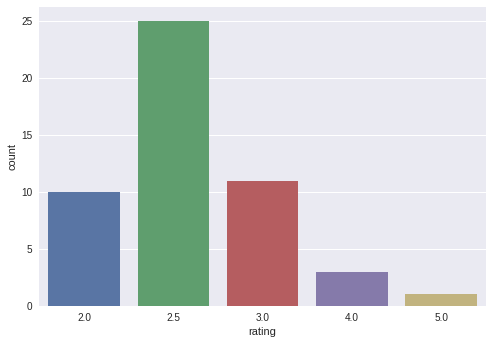

In [15]:
sns.countplot(x="rating", data=list_buss)

In [41]:
list_buss.groupby('price').count()

,id,rating,count,latitude,longitude
price,,,,,
$,10,10,10,10,10
$$,35,35,35,35,35
$$$,2,2,2,2,2


review

In [17]:
data["businesses"][0]['id'] # parse id# for review 

'5WHpzFh-ZbTBY919PlZPTw'

read review of this businesses 

In [0]:
ENDPOINT_reviews = 'https://api.yelp.com/v3/businesses/5WHpzFh-ZbTBY919PlZPTw/reviews'   # id/reviews  
response_reviews = requests.get(url = ENDPOINT_reviews, headers = HEADERS)

Each business has three reviews. Read first review

In [19]:
len(response_reviews.json())

3

In [20]:
response_reviews.json()['reviews'][0]#['user']['profile_url']

{'id': '3gnJ62usiQh9VDdVPibDAw',
 'rating': 4,
 'text': 'I have been here at 630 am and the staff is always pleasant and well rested. Sometimes there are homeless people sitting in the seats but it may be a way of...',
 'time_created': '2018-11-16 14:36:46',
 'url': 'https://www.yelp.com/biz/starbucks-new-york-273?adjust_creative=fl6Gc_WOT5VLrae0o6fc7w&hrid=3gnJ62usiQh9VDdVPibDAw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=fl6Gc_WOT5VLrae0o6fc7w',
 'user': {'id': 'KVKIvMY5gL5scNgexlENiQ',
  'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/iMhwNj0d6t8ZZJ1sS2i6qg/o.jpg',
  'name': 'Dionne H.',
  'profile_url': 'https://www.yelp.com/user_details?userid=KVKIvMY5gL5scNgexlENiQ'}}

Since each buisness only has three reviews, the rating are not representive the business statistically. So I decide to pull out the rating that directly link to the review.

In [0]:
# collect review
List_all_review = []
List_all_rating = []
for i in range(50):

  try:
    ENDPOINT_reviews = 'https://api.yelp.com/v3/businesses/'+ data["businesses"][i]['id'] +'/reviews'
    response_reviews = requests.get(url = ENDPOINT_reviews, headers = HEADERS)
    for ii in range(3):

      x = response_reviews.json()['reviews'][ii]['text']
      List_all_review .append(x)
      y = response_reviews.json()['reviews'][ii]['rating']
      List_all_rating.append(y)
  except:
    pass

In [45]:
d = {'rate': List_all_rating, 'review': List_all_review}
df_total = pd.DataFrame(data=d)
df_total.head()

,rate,review
0,4,I have been here at 630 am and the staff is al...
1,2,"Horrible experience this morning ,app orders s..."
2,1,I freqent this location practically every work...
3,3,I arrived extremely early in NY so I decided t...
4,3,"When I was younger, I used to play a game with..."


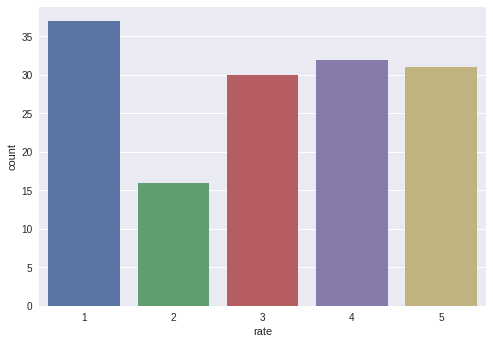

In [46]:
sns.countplot(x="rate", data=df_total)

In [0]:
df_total['Polarity'] = [TextBlob(x).sentiment[0] for x in df_total['review'] ]
df_total['Subjectivity'] = [TextBlob(x).sentiment[1] for x in df_total['review'] ]

In [48]:
df_total_HR = df_total[df_total['rate']>=4]
df_total_LR = df_total[df_total['rate']<4]

print(len(df_total_HR))
print(len(df_total_LR))

63
83


In [49]:
df_total_HR.head()

,rate,review,Polarity,Subjectivity
0,4,I have been here at 630 am and the staff is al...,0.733333,0.966667
6,5,My go to Starbucks. Obviously people don't agr...,0.400000,0.600000
8,4,This location is kind of tucked away in the mi...,0.150000,0.325000
9,4,One of my usual spots for a Starbucks run whil...,0.106667,0.380000
10,5,I been here a few times. The service is pretty...,0.220000,0.545000


In [50]:
df_total_LR.head()

,rate,review,Polarity,Subjectivity
1,2,"Horrible experience this morning ,app orders s...",-0.266667,0.70
2,1,I freqent this location practically every work...,-0.450000,1.00
3,3,I arrived extremely early in NY so I decided t...,0.100000,0.30
4,3,"When I was younger, I used to play a game with...",-0.133333,0.30
5,1,The wait here I just had for only a cup of ice...,-0.103472,0.75


Howis the review rate correlated to the polarity?

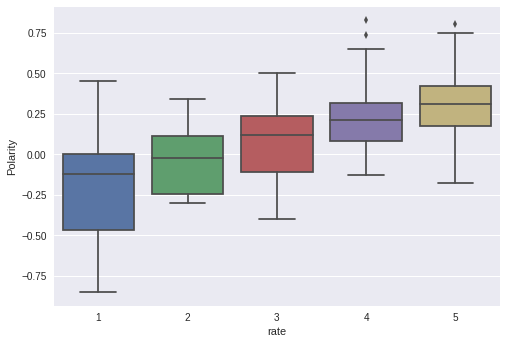

In [51]:
sns.boxplot(x="rate", y="Polarity", data=df_total)

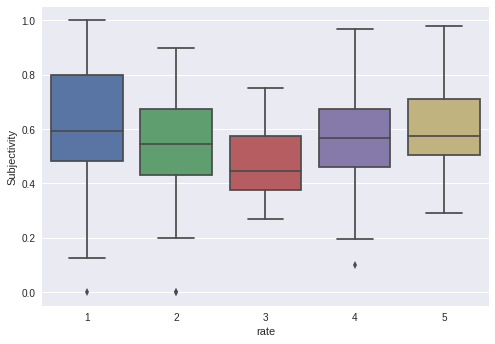

In [52]:
sns.boxplot(x="rate", y="Subjectivity", data=df_total)

In [0]:
df_total.head()

NameError: ignored